## IMPORT LIBRARIES

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *
import mpl_toolkits.mplot3d 
from sklearn import datasets
from sklearn.cluster import KMeans

In [35]:
# Define a function to calculate the ulcer index
def m_ulcer_index(series):
    drawdown = (series - series.cummax()) / series.cummax()
    squared_average = (drawdown ** 2).mean()
    return squared_average ** 0.5

In [36]:
# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y

# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ( (pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2 ) ** 0.5 + ( (pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2 ) ** 0.5, # Euclidean distance
        2: lambda x, y: abs( (slope * x + intercept) - y ) / (slope ** 2 + 1) ** 0.5, # Perpendicular distance
        3: lambda x, y: abs( (slope * x + intercept) - y ) # Vertical distance
    }
    return dist_funcs[dist_measure](i, data[i])

In [37]:

data = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
data = data.set_index('time')
# take data from 2007 to 2014
data = data['2007-01-01':'2008-01-01']

# add new columns from the time column, year, month, day, hour, minute
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data

,open,high,low,close,volume,year,month,day,hour,minute
time,,,,,,,,,,
2007-01-01 21:30:00+00:00,1.95840,1.95860,1.95840,1.95840,18,2007,1,1,21,30
2007-01-01 21:45:00+00:00,1.95840,1.95965,1.95830,1.95920,47,2007,1,1,21,45
2007-01-01 22:00:00+00:00,1.95910,1.96005,1.95890,1.95978,60,2007,1,1,22,0
2007-01-01 22:15:00+00:00,1.96003,1.96190,1.96003,1.96156,91,2007,1,1,22,15
2007-01-01 22:30:00+00:00,1.96138,1.96174,1.96083,1.96174,82,2007,1,1,22,30
...,...,...,...,...,...,...,...,...,...,...
2008-01-01 22:45:00+00:00,1.98707,1.98725,1.98661,1.98670,45,2008,1,1,22,45
2008-01-01 23:00:00+00:00,1.98670,1.98905,1.98670,1.98905,71,2008,1,1,23,0
2008-01-01 23:15:00+00:00,1.98868,1.98965,1.98868,1.98940,90,2008,1,1,23,15


In [38]:
n_close_points = 24
n_perc_points = 5
dist_measure = 1
pips_y_list = []
future_candles = 10
# loop through the data
# start from the 24th point
for index in range(n_close_points, len(data)):
    try:
        x_close = data['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = data['year'].iloc[j]
        pips_y_dict['month'] = data['month'].iloc[j]
        pips_y_dict['day'] = data['day'].iloc[j]
        pips_y_dict['hour'] = data['hour'].iloc[j]
        pips_y_dict['minute'] = data['minute'].iloc[j]
        pips_y_dict['close'] = data['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / data['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = data['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break

pips_y_df = pd.DataFrame(pips_y_list)
pips_y_df_np = pips_y_df.to_numpy()

An exception occurred


In [42]:
np.random.seed(5)

# standard scale the 'hour', 'minute', 'current_log_ratio' columns
pips_y_df[['day', 'hour', 'minute']] = StandardScaler().fit_transform(pips_y_df[['day', 'hour', 'minute']])
pips_y_df_np = pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4', 'day', 'hour', 'minute']].to_numpy()
kmeans = KMeans(n_clusters=36)
kmeans.fit(pips_y_df_np)
labels = kmeans.labels_

In [43]:
# add a new column namely k_label using labels to pips_y_df
pips_y_df['k_label'] = labels
train_pips_y_df = pips_y_df.copy()

In [44]:
k_label_log_ratio_df = train_pips_y_df[(train_pips_y_df['future_log_ratio'] < 6) & (train_pips_y_df['future_log_ratio'] > -6)]
k_label_log_ratio_df = k_label_log_ratio_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)
k_label_log_ratio_df

k_label
18    247.485304
28    232.561274
8     194.955641
27    183.140963
19    166.967746
2     143.528601
15    139.686074
7     137.466864
0     135.869297
30    135.708981
24    120.233876
21    115.003903
13    104.956708
35    100.474479
22     99.040828
25     91.812825
34     91.278076
6      79.795187
16     72.626845
9      56.752589
17     56.146580
4      46.004596
26     27.846521
20     24.419458
29     15.487392
11      6.027698
32      0.686050
33     -8.745987
31    -17.089224
1     -19.821584
10    -50.564943
12    -70.000362
5     -78.855733
23   -101.213255
14   -110.220574
3    -110.645911
Name: future_log_ratio, dtype: float64

# TESTING THE MODEL

In [ ]:
test_df = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
test_df = test_df.set_index('time')
# take data from 2007 to 2014
test_df = test_df['2008-01-01':'2008-06-01']

# add new columns from the time column, year, month, day, hour, minute
test_df['year'] = test_df.index.year
test_df['month'] = test_df.index.month
test_df['day'] = test_df.index.day
test_df['hour'] = test_df.index.hour
test_df['minute'] = test_df.index.minute
test_df

n_close_points = 24
n_perc_points = 4
dist_measure = 1
pips_y_list = []
future_candles = 10
for index in range(n_close_points, len(test_df)):
    try:
        x_close = test_df['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = test_df['year'].iloc[j]
        pips_y_dict['month'] = test_df['month'].iloc[j]
        pips_y_dict['day'] = test_df['day'].iloc[j]
        pips_y_dict['hour'] = test_df['hour'].iloc[j]
        pips_y_dict['minute'] = test_df['minute'].iloc[j]
        pips_y_dict['close'] = test_df['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / test_df['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = test_df['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break

pips_y_test_df = pd.DataFrame(pips_y_list)
pips_y_test_df_np = pips_y_test_df.to_numpy()

In [ ]:
np.random.seed(5)

# standard scale the 'hour', 'minute', 'current_log_ratio' columns
pips_y_test_df[['hour', 'minute', 'current_log_ratio']] = StandardScaler().fit_transform(pips_y_test_df[['hour', 'minute', 'current_log_ratio']])
pips_y_test_df_np = pips_y_test_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'hour', 'minute', 'current_log_ratio']].to_numpy()
y_test_pred = kmeans.predict(pips_y_test_df_np)
pips_y_test_df['k_label'] = y_test_pred
y_test_pips_df = pips_y_test_df.copy()
y_test_pips_df

In [ ]:
y_test_pips_grouped_df = y_test_pips_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)
y_test_pips_grouped_df

## GRAPHS AND ILLUSTRATIONS

In [ ]:
# plot the histogram
pips_y_df.hist(bins=100)

In [ ]:
import ffn as ffn
import empyrical as ep

test_k_label = 14
test_pips_y_copy_df = train_pips_y_df[(train_pips_y_df['k_label'] == test_k_label)]
test_k_label_cumsum = test_pips_y_copy_df['future_log_ratio'].cumsum()
test_k_label_cumsum = test_k_label_cumsum.reset_index(drop=True)
test_k_label_cumsum.plot()

# Add a constant value to the series
test_k_label_cumsum = test_k_label_cumsum + 100
n_period = 252
# n_period = len(test_k_label_cumsum)
rf = 0.01

first_return = test_k_label_cumsum.iloc[0]
last_return = test_k_label_cumsum.iloc[-1]
annualized_return = (last_return/first_return) ** (1 / 1) - 1
annualized_std = test_k_label_cumsum.std()
ulcer_index = m_ulcer_index(test_k_label_cumsum)
max_drawdown = ffn.calc_max_drawdown(test_k_label_cumsum)
martin_ratio = (annualized_return*100 - rf) / ulcer_index
sharp_ratio = (annualized_return*100 - rf) / annualized_std

# Print the results
calmar_ratio = percent_return / abs(max_drawdown)
print("Calmar ratio:", calmar_ratio)


print("Annualized return:", annualized_return)
print("Annualized standard deviation:", annualized_std)
print("Ulcer index:", ulcer_index)
print("Martin ratio:", martin_ratio)
print("Max drawdown:", max_drawdown)
print("Sharp ratio:", sharp_ratio)

In [ ]:
last_return - first_return

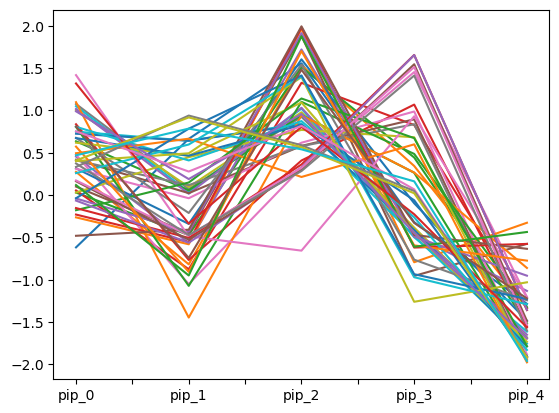

In [49]:
m_k_label = 2
k_label_sub_df = train_pips_y_df[train_pips_y_df['k_label'] == m_k_label]
for i in range(50):
    k_label_sub_df.iloc[i][['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4']].plot()
plt.show()

In [ ]:
test_k_label_cumsum

In [ ]:
np.random.seed(5)
# X = pips_y_df_np
X = pips_y_df_np[:700]

estimators = [
    ("k_means_24", KMeans(n_clusters=24)),
    ("k_means_3", KMeans(n_clusters=3)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(13, 10))
titles = ["24 clusters", "3 clusters", "3 clusters, bad init"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("p0")
    ax.set_ylabel("p1")
    ax.set_zlabel("p2")
    ax.set_title(title)

plt.show()